In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import time
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
plt.style.use("ggplot")

from mixedbridge.stochastic_processes.examples import BrownianProcess, BrownianAuxProcess, BrownianBridgeProcess
from mixedbridge.stochastic_processes.gbp import GuidedBridgeProcess, NeuralGuidedBridgeProcess
from mixedbridge.solvers.sde import WienerProcess, Euler, ModifiedEuler
from mixedbridge.utils.plotting import plot_sample_path

# Guiding Brownian bridge with another Brownian process
We use a Brownian bridge with constant drift as the target bridge, and approximate it by learning from another Brownian bridge without drift, specifically:
$$
\mathrm{d}X_t = \gamma\mathrm{d}t + \sigma\mathrm{d}W_t \\
\mathrm{d}X^{\star}_t = \left\{\gamma + \frac{v - X^{\star}_t - \gamma * (T - t)}{T-t}\right\}\mathrm{d}t + \sigma\mathrm{d}W_t = \left\{\frac{v - X^{\star}_t}{T-t}\right\}\mathrm{d}t + \sigma\mathrm{d}W_t
$$
And the auxiliary and guided processes are:
$$
\mathrm{d}\tilde{X}_t = \sigma\mathrm{d}W_t \\
\mathrm{d}X^{\circ}_t = \left\{\gamma + \frac{v - X^{\circ}_t}{T-t}\right\}\mathrm{d}t + \sigma\mathrm{d}W_t
$$
Therefore, if the neural guided process is constructed as:
$$
\mathrm{d}X^{\diamond}_t = \left\{\gamma + \frac{v - X^{\circ}_t}{T-t} + \sigma\nu_{\theta}(t, X^{\diamond}_t)\right\}\mathrm{d}t + \sigma\mathrm{d}W_t
$$
We can expect:
$$
\nu_{\theta^*}(t, x) = -\frac{\gamma}{\sigma}
$$

In [3]:
dim = 1
T = 1.0
dt = 1. / 200
dtype = jnp.float32

gamma = 2.0
sigma = 1.0

rng_key = jax.random.PRNGKey(42)
x0 = jnp.array([0.0], dtype=dtype)
v  = jnp.array([0.0], dtype=dtype)

In [6]:
t_scheme = "linear"
ode_solver_kernel = "dopri5"

wiener_proc        = WienerProcess(T=T, dt=dt, dim=dim, t_scheme=t_scheme, dtype=dtype)
ori_proc           = BrownianProcess(gamma=gamma, sigma=sigma, T=T, dim=dim, dtype=dtype)
aux_proc           = BrownianAuxProcess(gamma=0.0, sigma=sigma, T=T, dim=dim, dtype=dtype)
true_bridge_proc   = BrownianBridgeProcess(gamma=gamma, sigma=sigma, score_fn=None, v=v, dtype=dtype, T=T)

guided_bridge_proc = GuidedBridgeProcess(ori_proc=ori_proc, 
                                         aux_proc=aux_proc, 
                                         x0=x0,
                                         v=v,
                                         L0=jnp.eye(dim, dtype=dtype), 
                                         Sigma0=jnp.eye(dim, dtype=dtype)*1e-10,
                                         ts=wiener_proc.ts,
                                         ode_solver_kernel=ode_solver_kernel)

true_bridge_solver   = Euler(sde=true_bridge_proc, wiener=wiener_proc)
guided_bridge_solver = Euler(sde=guided_bridge_proc, wiener=wiener_proc)

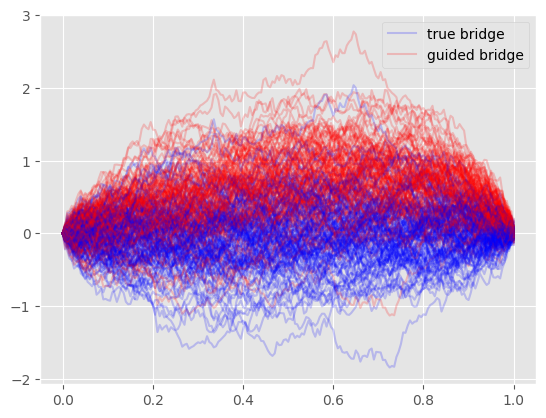

In [7]:
batch_size = 128
# dWs = jnp.zeros((n_samples, int(T/dt), dim))
dWs = None
true_bridge_paths   = true_bridge_solver.solve(x0=x0, rng_key=rng_key, dWs=dWs, batch_size=batch_size)
guided_bridge_paths = guided_bridge_solver.solve(x0=x0, rng_key=rng_key, dWs=dWs, batch_size=batch_size)

plt.figure()
for i in range(batch_size):
    plt.plot(true_bridge_paths.ts, true_bridge_paths.xs[i], color='blue', alpha=0.2)
    plt.plot(guided_bridge_paths.ts, guided_bridge_paths.xs[i], color='red', alpha=0.2)

plt.plot([], [], color='blue', label='true bridge', alpha=0.2)
plt.plot([], [], color='red', label='guided bridge', alpha=0.2)
plt.legend()
plt.show()

## NN training

In [6]:
import flax.linen as nn
from flax import struct
from flax.training import train_state
import optax

In [19]:
# a very simple MLP
class MLP(nn.Module):
    
    @nn.compact
    def __call__(self, t, x, training=False):
        t = nn.Dense(16)(t)
        t = nn.tanh(t)
        x = nn.Dense(16)(x)
        x = nn.tanh(x)
        x = jnp.concatenate([t, x], axis=-1)
        x = nn.Dense(32)(x)
        x = nn.BatchNorm(use_running_average=not training)(x)
        x = nn.tanh(x)
        x = nn.Dense(64)(x)
        x = nn.BatchNorm(use_running_average=not training)(x)
        x = nn.tanh(x)
        x = nn.Dense(32)(x)
        x = nn.BatchNorm(use_running_average=not training)(x)
        x = nn.tanh(x)
        x = nn.Dense(dim)(x)
        return x


In [28]:
@struct.dataclass
class TrainState(train_state.TrainState):
    batch_stats: dict = struct.field(pytree_node=True)

    @classmethod
    def create(cls, *, apply_fn, params, tx, batch_stats, **kwargs):
        """Creates a new instance with `step=0` and initialized `opt_state`."""
        opt_state = tx.init(params)
        return cls(
            step=0,
            apply_fn=apply_fn,
            params=params,
            tx=tx,
            opt_state=opt_state,
            batch_stats=batch_stats,
            **kwargs,
        )

def train_model(rng_key, model, path_solver, n_epochs, n_iters, batch_size):
    rng_key, init_key = jax.random.split(rng_key)
    
    dummy_t, dummy_x = jnp.zeros((1, 1)), jnp.zeros((1, 1))
    variables = model.init(init_key, dummy_t, dummy_x, training=True)
    # variables = model.init(init_key, dummy_x, training=True)
    params = variables['params']
    batch_stats = variables['batch_stats'] if 'batch_stats' in variables else {}
    
    optimizer = optax.chain(
        optax.clip_by_global_norm(1.0),
        optax.adam(2e-4),
        optax.ema(0.995)
    )
    
    model_state = TrainState.create(
        apply_fn=model.apply,
        params=params,
        tx=optimizer,
        batch_stats=batch_stats
    )

    def sample_path(rng_key, path_solver):
        path = path_solver.solve(x0=x0, dWs=None, rng_key=rng_key, batch_size=batch_size, enforce_end_point=v)
        ts, xs, dWs, log_ll = path.ts, path.xs, path.dWs, path.log_likelihood
        ts = jnp.tile(jnp.expand_dims(ts, axis=0), reps=(batch_size, 1))
        return ts, xs, dWs, log_ll

    def compute_loss(params, batch_stats, ts, xs, dWs, log_ll, state):
        variables = {'params': params, 'batch_stats': batch_stats}
        ts = ts[:, :-1]               # (batch_size, n_steps + 1) -> (batch_size, n_steps)
        xs = xs[:, :-1, :]            # (batch_size, n_steps + 1, dim) -> (batch_size, n_steps, dim)
        ts_flatten = jnp.reshape(ts, (-1, 1))  # (batch_size, n_steps) -> (batch_size * n_steps, 1)
        xs_flatten = jnp.reshape(xs, (-1, dim)) # (batch_size, n_steps, dim) -> (batch_size * n_steps, dim)
        nus, updated_batch_stats = state.apply_fn(
            variables, 
            t=ts_flatten, 
            x=xs_flatten, 
            training=True,
            mutable=['batch_stats']
        )   # nus shape: (batch_size * n_steps, dim)
        nus = jnp.reshape(nus, (batch_size, -1, dim)) # (batch_size * n_steps, dim) -> (batch_size, n_steps, dim)
        sto_int = jnp.einsum("...i, ...i -> ...", nus, dWs)
        sto_int = jnp.sum(sto_int, axis=1)
        ll = jnp.exp(log_ll)
        det_int = 0.5 * jnp.sum(jnp.sum(jnp.square(nus), axis=-1), axis=1) * dt
        loss = ll * (-sto_int + det_int)
        return jnp.mean(loss), {"ll": ll, "sto_int": sto_int, "det_int": det_int, "batch_stats": updated_batch_stats['batch_stats']}
    
    @jax.jit
    def train_step(state, ts, xs, dWs, log_ll):
        def loss_fn(params):
            loss, aux = compute_loss(params, state.batch_stats, ts, xs, dWs, log_ll, state)
            return loss, aux
        
        (loss, aux), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
        state = state.apply_gradients(grads=grads)
        # Update batch_stats
        state = state.replace(batch_stats=aux['batch_stats'])
        return state, loss, grads, aux
    
    losses = []
    lls = []
    sto_ints = []
    det_ints = []
    gradient_norms = []
    
    for epoch in range(1, n_epochs + 1):
        start_time = time.time()
        epoch_losses = []
        epoch_grad_norms = []
        for iter in range(n_iters):
            rng_key, _ = jax.random.split(rng_key)
            ts, xs, dWs, log_ll = sample_path(rng_key, path_solver)
            model_state, loss, grads, aux = train_step(model_state, ts, xs, dWs, log_ll)
            
            sto_ints.append(aux["sto_int"])
            det_ints.append(aux["det_int"])
            lls.append(aux["ll"])
            
            if jnp.isnan(loss):
                raise ValueError(f"NaN loss detected. Last valid loss: {losses[-1] if losses else None}")
            
            losses.append(loss)
            epoch_losses.append(loss)
            
            # Compute gradient norm
            grad_norm = jnp.sqrt(sum([jnp.sum(jnp.square(g)) for g in jax.tree_util.tree_leaves(grads)]))
            
            if jnp.isnan(grad_norm):
                raise ValueError(f"NaN gradient norm detected. Current loss: {losses[-1] if losses else None}, Last valid gradient norm: {gradient_norms[-1] if gradient_norms else None}")
            
            gradient_norms.append(grad_norm)
            epoch_grad_norms.append(grad_norm)
        
        avg_loss = jnp.mean(jnp.array(epoch_losses))
        avg_grad_norm = jnp.mean(jnp.array(epoch_grad_norms))
        print(f"Epoch {epoch:<3} / {n_epochs}, avg loss: {avg_loss:.5f}, avg grad norm: {avg_grad_norm:.5f}, time: {time.time() - start_time:.2f}s")

    return model_state, losses, gradient_norms, lls, sto_ints, det_ints

In [38]:
model = MLP()
n_epochs = 20
n_iters = 1000
batch_size = 256

In [39]:
model_state, losses, gradient_norms, lls, sto_ints, det_ints = train_model(rng_key, model, guided_bridge_solver, n_epochs, n_iters, batch_size) 

Epoch 1   / 20, avg loss: -0.22486, avg grad norm: 0.69666, time: 18.90s
Epoch 2   / 20, avg loss: -0.24203, avg grad norm: 0.52079, time: 18.60s
Epoch 3   / 20, avg loss: -0.26430, avg grad norm: 0.55624, time: 18.54s
Epoch 4   / 20, avg loss: -0.26208, avg grad norm: 0.55753, time: 18.54s
Epoch 5   / 20, avg loss: -0.26003, avg grad norm: 0.64793, time: 18.49s
Epoch 6   / 20, avg loss: -0.24814, avg grad norm: 0.49686, time: 18.39s
Epoch 7   / 20, avg loss: -0.25534, avg grad norm: 0.50916, time: 18.85s
Epoch 8   / 20, avg loss: -0.26194, avg grad norm: 0.49793, time: 18.67s
Epoch 9   / 20, avg loss: -0.26543, avg grad norm: 0.41888, time: 18.62s
Epoch 10  / 20, avg loss: -0.27106, avg grad norm: 0.62491, time: 18.56s
Epoch 11  / 20, avg loss: -0.26718, avg grad norm: 0.49375, time: 18.61s
Epoch 12  / 20, avg loss: -0.26478, avg grad norm: 0.56844, time: 18.65s
Epoch 13  / 20, avg loss: -0.28988, avg grad norm: 0.79569, time: 18.53s
Epoch 14  / 20, avg loss: -0.25301, avg grad norm: 

#### Training logs

In [22]:
lls = jnp.array(lls)    
sto_ints = jnp.array(sto_ints)
det_ints = jnp.array(det_ints)
print(lls.shape, sto_ints.shape, det_ints.shape)

(10000, 128) (10000, 128) (10000, 128)


In [23]:
print(sto_ints.max(), sto_ints.min(), sto_ints.std())
print(det_ints.max(), det_ints.min(), det_ints.std())
print(lls.max(), lls.min(), lls.std())


40.305214 -3.2227511 2.9642851
32.797127 0.00019753046 2.5822434
370.467 1.0793536e-06 0.91524875


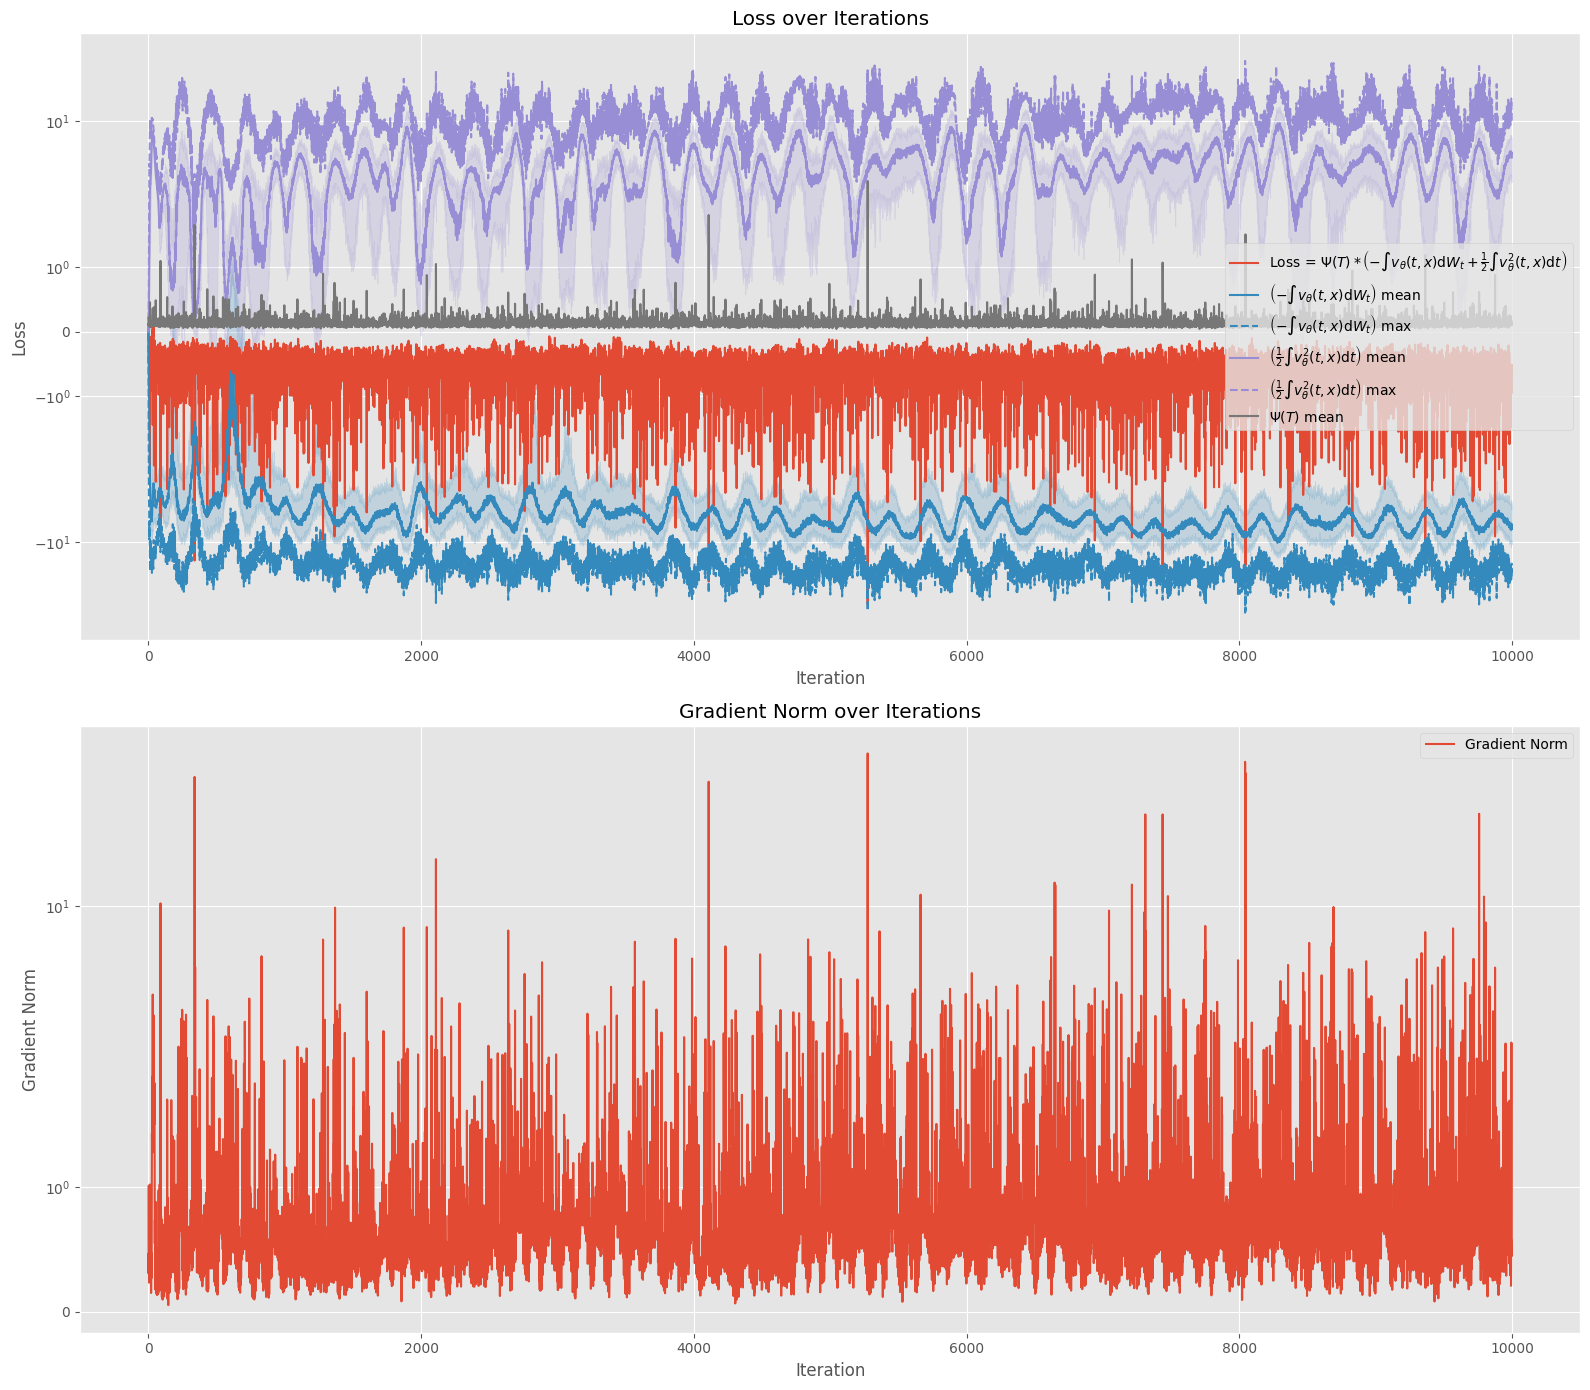

In [24]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 14))

# Plotting the losses
ax1.plot(losses, label=r'Loss = $\Psi(T) * \left(-\int v_{\theta}(t, x)\mathrm{d}W_t + \frac{1}{2}\int v_{\theta}^2(t, x)\mathrm{d}t\right)$')
mean = -sto_ints.mean(axis=1)
std = sto_ints.std(axis=1)
ax1.plot(mean, label=r'$\left(-\int v_{\theta}(t, x)\mathrm{d}W_t\right)$ mean')
ax1.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.2, color=ax1.lines[1].get_color())
ax1.plot(-sto_ints.max(axis=1), label=r'$\left(-\int v_{\theta}(t, x)\mathrm{d}W_t\right)$ max', linestyle='--', color=ax1.lines[1].get_color())
mean = det_ints.mean(axis=1)
std = det_ints.std(axis=1)
ax1.plot(mean, label=r'$\left(\frac{1}{2}\int v_{\theta}^2(t, x)\mathrm{d}t\right)$ mean')
ax1.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.2, color=ax1.lines[3].get_color())
ax1.plot(det_ints.max(axis=1), label=r'$\left(\frac{1}{2}\int v_{\theta}^2(t, x)\mathrm{d}t\right)$ max', linestyle='--', color=ax1.lines[3].get_color())
mean = lls.mean(axis=1)
std = lls.std(axis=1)
ax1.plot(mean, label=r'$\Psi(T)$ mean')
# ax1.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.2, color=ax1.lines[4].get_color())
# ax1.plot(lls.max(axis=1), label=r'$\Psi(T)$ max', linestyle='--', color=ax1.lines[5].get_color())
ax1.set_yscale('symlog')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss')
ax1.set_title('Loss over Iterations')
ax1.legend()
ax1.grid(True)


# Plotting the gradient norms
ax2.plot(gradient_norms, label='Gradient Norm')
ax2.set_yscale('symlog')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Gradient Norm')
ax2.set_title('Gradient Norm over Iterations')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

#### Evaluation

In [40]:
def nu_learned(t, x):
    return model_state.apply_fn(
        {"params": model_state.params, "batch_stats": model_state.batch_stats}, 
        jnp.array([t], dtype=dtype), 
        x, 
        training=False,
        mutable=False
    )


In [9]:
nu_learned = lambda t, x: - gamma / sigma * jnp.ones_like(x)

mixed_bridge_proc = NeuralGuidedBridgeProcess(
    ori_proc=ori_proc,
    aux_proc=aux_proc,
    x0=x0,
    v=v,
    nu=nu_learned,
    ts=wiener_proc.ts,
    L0=jnp.eye(dim, dtype=dtype),
    Sigma0=jnp.eye(dim, dtype=dtype)*1e-10,
)

In [10]:
mixed_bridge_solver = Euler(sde=mixed_bridge_proc, wiener=wiener_proc)
mixed_bridge_paths = mixed_bridge_solver.solve(x0=x0, dWs=None, rng_key=rng_key, batch_size=16)
true_bridge_paths = true_bridge_solver.solve(x0=x0, dWs=None, rng_key=rng_key, batch_size=16)

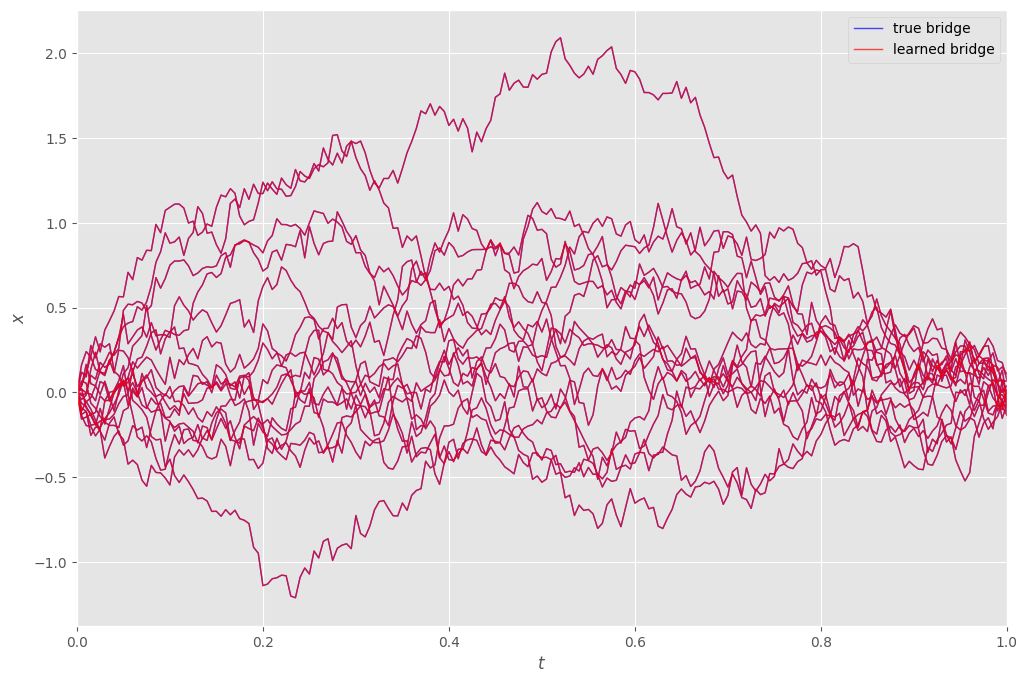

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
plot_sample_path(true_bridge_paths, ax=ax, colors=('blue',), labels=('true bridge',))
plot_sample_path(mixed_bridge_paths, ax=ax, colors=('red',), labels=('learned bridge',))
plt.legend()
# plt.savefig('brownian_bridge_kld_loss.png', dpi=300)
plt.show()